In [1]:
#import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [2]:
#%lsmagic

In [3]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

import random
import tensorflow_addons as tfa
import math

from tensorflow.keras import layers
start = dt.datetime.now()

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
  except RuntimeError as e:
    print(e)

In [5]:
DP_DIR = 'D:/Desktop/shuffle-csvs/'
INPUT_DIR = 'D:Desktop/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.random.set_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [6]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)


MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications


In [7]:
STEPS = 10000
EPOCHS = 100
size = 64
batchsize = 980

In [8]:
def toy_resnet(input_shape=(size, size, 1), classes=NCATS):
    
    inputs = keras.Input(shape=(64, 64, 1), name="img")
    
    x = layers.ZeroPadding2D((3,3))(inputs)
    
    #---------
    x = layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    
    #---------conv 1 a
    x_1 = x
    x = layers.Conv2D(64, (1, 1), strides = (2,2))(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x_1 = layers.Conv2D(256, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(x_1)
    x_1 = layers.BatchNormalization(axis=3)(x_1)
    
    #=========
    x = Add()([x,x_1])
    x = Activation('elu')(x)    
    
     
    #---------id 1 a
    x_2 = x
    x = layers.Conv2D(64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_2])
    x = Activation('elu')(x)
    
    #---------id 2 a
    x_3 = x
    x = layers.Conv2D(64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
        
    #=========
    x = Add()([x,x_3])
    x = Activation('elu')(x)
    
    
    #---------conv 1 b
    x_4 = x
    x = layers.Conv2D(128, (1, 1), strides = (2,2))(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x_4 = layers.Conv2D(512, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(x_4)
    x_4 = layers.BatchNormalization(axis=3)(x_4)
    
    #=========
    x = Add()([x,x_4])
    x = Activation('elu')(x)    
    
    
    #---------id 1 b
    x_5 = x
    x = layers.Conv2D(128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_5])
    x = Activation('elu')(x) 
    
    
    #---------id 2 b
    x_6 = x
    x = layers.Conv2D(128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_6])
    x = Activation('elu')(x) 
    
    
    #---------id 2 c
    x_7 = x
    x = layers.Conv2D(128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    x = Activation('elu')(x)
    
    #=========
    x = layers.Conv2D(512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(x) 
    x = layers.BatchNormalization(axis=3)(x)
    
    #=========
    x = Add()([x,x_7])
    x = Activation('elu')(x) 
    
    
    #---------
    x = layers.AveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = Dense(NCATS, activation = 'softmax')(x)
    
    model = keras.Model(inputs, x, name="toy_resnet")
    
    return model

In [9]:
model = toy_resnet(input_shape=(size, size, 1), classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           img[0][0]                        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
_________________________________________________________________________________________

Training with Image Generator

In [10]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    r = random.randint(0,19)
                    if(r == 1):
                        r1 = random.randint(0,len(raw_strokes)-1)
                        r2 = random.randint(0,len(raw_strokes[r1][0])-1)
                        r3 = random.randint(0,len(raw_strokes[r1][1])-1)
                        raw_strokes[r1][0][r2] = random.randint(0,256)
                        raw_strokes[r1][1][r3] = random.randint(0,256)                    
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                    r = random.randint(0,19)
                    if(r == 1):
                        x[i, :, :, 0] = tfa.image.rotate(x[i, :, :, 0], random.randint(-30,30) * math.pi / 180, interpolation='BILINEAR')
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [11]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [12]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

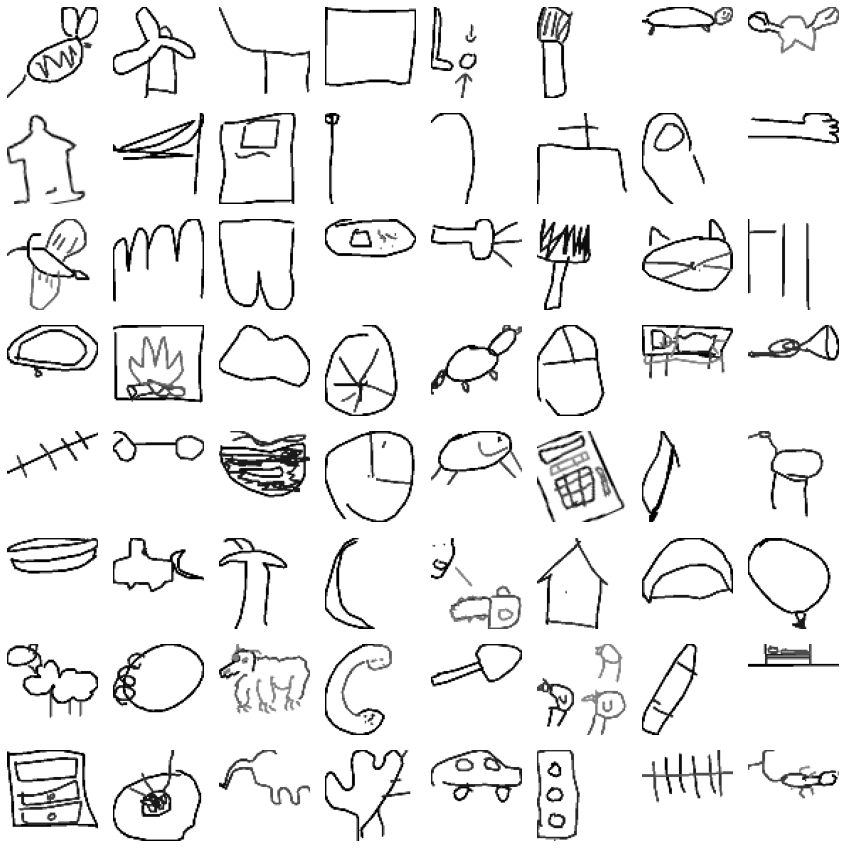

In [13]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [14]:
%%timeit
x, y = next(train_datagen)

250 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
callbacks = [
    ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.75, patience=5, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('modelelperepoch.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=False),
    EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=False)

]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=100, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
10000/10000 [==============================] - 4138s 414ms/step - loss: 1.3462 - categorical_crossentropy: 1.3462 - categorical_accuracy: 0.6703 - top_3_accuracy: 0.8387 - val_loss: 1.0967 - val_categorical_crossentropy: 1.0967 - val_categorical_accuracy: 0.7250 - val_top_3_accuracy: 0.8784
Epoch 2/100
10000/10000 [==============================] - 3880s 388ms/step - loss: 1.0566 - categorical_crossentropy: 1.0566 - categorical_accuracy: 0.7329 - top_3_accuracy: 0.8845 - val_loss: 1.0384 - val_categorical_crossentropy: 1.0384 - val_categorical_accuracy: 0.7361 - val_top_3_accuracy: 0.8877
Epoch 3/100
10000/10000 [==============================] - 3894s 389ms/step - loss: 0.9814 - categorical_crossentropy: 0.9814 - categorical_accuracy: 0.7500 - top_3_accuracy: 0.8950 - val_loss: 0.9637 - val_categorical_crossentropy: 0.9637 - val_categorical_accuracy: 0.7535 - val_top_3_accuracy: 0.8996
Epoch 4/100


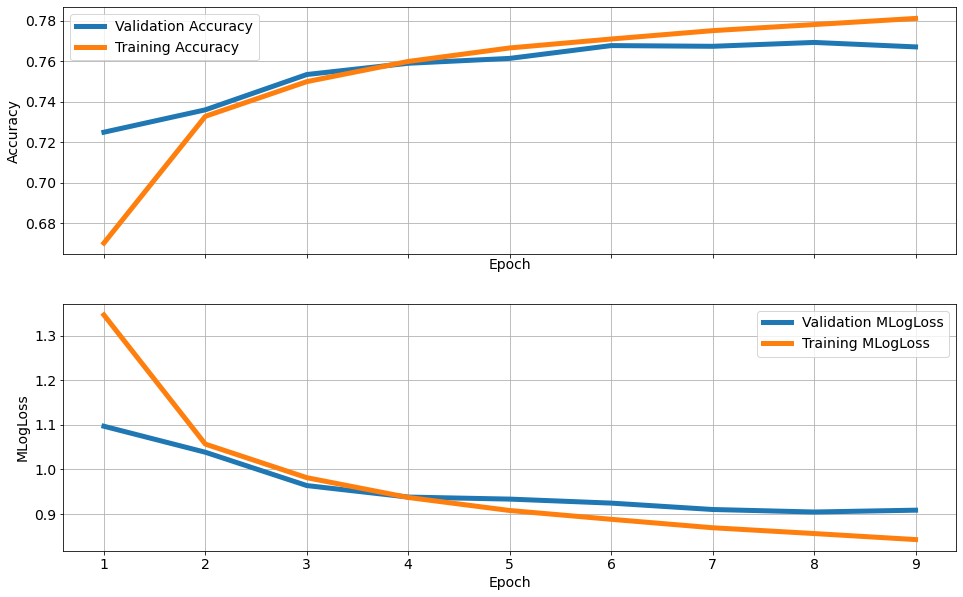

In [16]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [17]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

266/266 [==============================] - 2s 9ms/step
Map3: 0.828


In [18]:
#model.save('my_modelel.h5') 